In [1]:
import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
from datetime import datetime
from time import gmtime, strftime, sleep

region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()                     
##prefix = 'xgb-10000871.csv-TC58-SW100-WC10-20201202080714'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC20-20201202051756'
#prefix = 'xgb-10000871.csv-TC58-SW100-WC40-20201202032834'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC60-20201202011847'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC80-20201202023456'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC99-20201202064356'
prefix = 'xgb-10000871_deal.csv-TC58-SW010-WC002-20210125021334' ##for cn demo 

#prefix_tuningjobname = prefix[-30:-15]#+'-'+strftime("%Y%m%d%H%M%S", gmtime())
prefix_tuningjobname = prefix[-31:-15]#+'-'+strftime("%Y%m%d%H%M%S", gmtime())


print(bucket)
print(prefix)
print(prefix_tuningjobname)


sagemaker-cn-northwest-1-337575217701
xgb-10000871_deal.csv-TC58-SW010-WC002-20210125021334
TC58-SW010-WC002


---

## Setup_Hyperparameter_Tuning 
*Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.*


Now that we have prepared the dataset, we are ready to train models. Before we do that, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, which includes:
* The container image for the algorithm (XGBoost)
* Configuration for the output of the training jobs
* The values of static algorithm hyperparameters, those that are not specified will be given default values
* The type and number of instances to use for the training jobs

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', repo_version='1')
#container = get_image_uri(boto3.Session().region_name, 'xgboost')
#display(container)

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='mae',
                        objective='binary:logistic')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


We will tune four hyperparameters in this examples:
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* *alpha*: L1 regularization term on weights. Increasing this value makes models more conservative. 
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

In [3]:
hyperparameter_ranges = {'num_round': IntegerParameter(100, 1000)}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [4]:
objective_metric_name = 'validation:mae'

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The XGBoost estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [5]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,                           
                            hyperparameter_ranges,
                            objective_type='Minimize',
                            base_tuning_job_name=prefix_tuningjobname,
                            max_jobs=6,
                            max_parallel_jobs=3)

## Launch_Hyperparameter_Tuning
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [38]:
### <AttributeError: module 'sagemaker' has no attribute 's3_input'> only working on sagemaker=  1.68.0 !!!
#!pip list 
#!pip install sagemaker==1.68.0
    

In [6]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [7]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [8]:
tuningjobname = tuner.latest_tuning_job.job_name
print(tuningjobname)

TC58-SW010-WC002-210125-0227


## Analyze tuning job results - after tuning job is completed
Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see example code to analyze the tuning job results.

## Deploy the best model
Now that we have got the best model, we can deploy it to an endpoint. Please refer to other SageMaker sample notebooks or SageMaker documentation to see how to deploy a model.

# Analyze Results of a Hyperparameter Tuning job

Once you have completed a tuning job, (or even while the job is still running) you can use this notebook to analyze the results to understand how each hyperparameter effects the quality of the model.

---
## Set up the environment
To start the analysis, you must pick the name of the hyperparameter tuning job.

In [9]:
import boto3
import sagemaker
import os

region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

## You must have already run a hyperparameter tuning job to analyze it here.
## The Hyperparameter tuning jobs you have run are listed in the Training section on your SageMaker dashboard.
## Copy the name of a completed job you want to analyze from that list.
## For example: tuning_job_name = 'mxnet-training-201007-0054'.
#tuning_job_name = 'YOUR-HYPERPARAMETER-TUNING-JOB-NAME'
tuning_job_name = tuningjobname

## Track hyperparameter tuning job progress
After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [10]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

Reminder: the tuning job has not been completed.
0 training jobs have completed


In [11]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

No training jobs have reported results yet.


## Fetch all results as DataFrame
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [12]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

No training jobs have reported valid results yet.


,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime


## See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses.  For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance _exploration_ of new areas of parameter space against _exploitation_ of known good areas.  This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [13]:
#!pip install bokeh

import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters 
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [14]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

# 提个醒
# 请手动部署最优的模型为 Endpoint，
* 步骤1：Create Model，name = prefix_tuningjobname
* 步骤2：Create endpoint，name = prefix_tuningjobname


In [53]:
prefix_tuningjobname

'TC58-SW010-WC008'

In [91]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
from datetime import datetime
from time import gmtime, strftime, sleep
import boto3
import sagemaker
from sagemaker import get_execution_role
#from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from time import sleep
import time

region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()


s3_wholedata_path = s3_data='s3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix)

#提醒，这里要改！：
endpoint_name = 'TC58-SW010-WC003-210111-0923-006-3fefd4b7' #'xgb-TC58-SW100-WC60-temp01'


#!pip install s3fs -U
role = get_execution_role()
model_data = pd.read_csv(s3_wholedata_path)
#model_data.head(3) #for testing
#model_data.info() #for testing
#prefix = 'xgb-10000871.csv-TC58-SW010-WC008-20210111073547'
#print(bucket)
#print(prefix)
print(prefix)
print(endpoint_name)



xgb-10000871.csv-TC58-SW010-WC003-20210111090949
TC58-SW010-WC003-210111-0923-006-3fefd4b7


In [92]:
#预测 1：准备sagemaker endpoint
xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

#from sagemaker.predictor import csv_serializer
from sagemaker.predictor import csv_serializer, json_deserializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [93]:
# inference预测处理：传入modeldata数据和 sagemaker inference handle，获得预测结果
def sagemaker_predict(data, xgb_predictor, rows=100):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))    
    predictions = ''
    for array in split_array:
        split_result = xgb_predictor.predict(data=array).decode('utf-8')
        #print(split_result)
        split_result = str.strip(split_result, '[]') # 去掉多余的前后[]符号
        #split_result=split_result.replace(' ', '')
        #print('res='+split_result)
             
        predictions = ','.join([predictions, split_result])
            
    #print(predictions)
    #return np.fromstring(predictions[1:], sep=',', dtype=np.float64) 
    return np.fromstring(predictions[1:], sep=',') 

#预测 2：预测并获得预测结果
model_data_to_numpy = model_data.to_numpy()[:, 1:] #转换所有的行，从第一列开始（忽略0列）

#调用函数
predictions = sagemaker_predict(model_data_to_numpy,xgb_predictor, rows=100)
#print('predictions=')
#print(predictions)
#print('predictions round=')
#print(np.round(predictions))
#print('\n')
#print('expect round=')
#print(model_data.to_numpy()[:, 0:1])

model_data: 1=76, 0=665 / 
predictions Result: 1=72, 0=669


predictions_data,0.0,1.0
model_data,,
0.0,663,2
1.0,6,70


<Figure size 432x288 with 0 Axes>

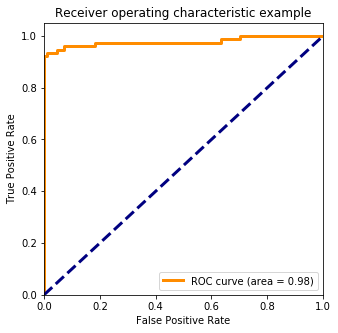

sklearn AUC: 0.9783735654926791

xgb_predictor.endpoint = TC58-SW010-WC003-210111-0923-006-3fefd4b7

s3_wholedata_path = s3://sagemaker-cn-northwest-1-337575217701/xgb-10000871.csv-TC58-SW010-WC003-20210111090949/wholedata/whole_data.csv


(None,)

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

y_labels = model_data.iloc[:, 0]
y_scores = predictions

#结果 1：测试数据集结果 与 预测结果 的数量对比
print('model_data: 1='+ str((y_labels == 1).sum()) + ', 0='+str((y_labels == 0).sum()) +' / '),
print('predictions Result: 1='+ str((np.round(y_scores) == 1).sum()) + ', 0='+str((np.round(y_scores) == 0).sum()))

#结果 2：交叉表，说明 测试数据集结果 与 预测结果 的正确情况对比
display(pd.crosstab(index=model_data.iloc[:, 0], columns=np.round(predictions), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False))
#print('\n')

#结果 4：ROC图，越大越好，无限接近与1
from sklearn.metrics import roc_curve, auc                     #导入库
fpr, tpr, thresholds  =  roc_curve(y_labels, y_scores)  #计算真正率和假正率
roc_auc = auc(fpr,tpr)                                         #计算auc的值
plt.figure()
lw = 3
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#结果 3：AUC值，越大越好，无限接近与1
import numpy as np
from sklearn.metrics import roc_auc_score
##y_labels=[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
##y_scores=[4.92438182e-01 1.74370125e-01 8.58997216e-01 1.30175965e-01 
# 调用sklearn中的方法计算AUC，与后面自己写的方法作对比
print('sklearn AUC:', roc_auc_score(y_labels, y_scores))
#打印全局变量值
print('\nxgb_predictor.endpoint = ' + str(xgb_predictor.endpoint)),
print('\ns3_wholedata_path = '+ str(s3_wholedata_path)),


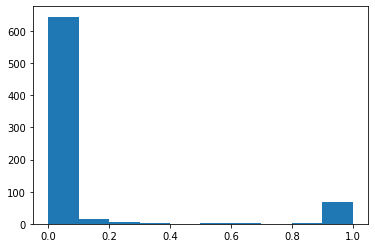

predictions_data,0,1
model_data,,
0.0,663,2
1.0,6,70


In [95]:
#结果 5：分布柱状图；用于分析和优化结果（round函数）；
plt.hist(predictions, bins=10, range=(0, 1))
plt.show()

#用于分析和优化结果（round函数）；
round_predictions=0.45
pd.crosstab(index=model_data.iloc[:, 0], columns=np.where(predictions > round_predictions, 1, 0), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False)
